# Gas powerplant investigation
- In this file I will make investigations that will be useful for the final program 

## Modeling lognormal variables 
- I am trying to see, how parameters influence the final price graph and what makes sense for gas and power prices. 

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
def plot_lognorm_price(delta, x, n):

    price = []
    for k in range(n):
        x = np.exp(np.log(x)+norm.rvs(scale = delta))
        price.append(x)
    plt.plot(price)
    plt.xlabel('days')
    plt.ylabel("EUR")

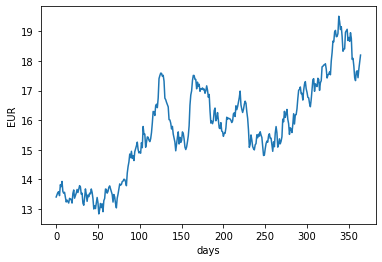

In [18]:
plot_lognorm_price(0.015, 13, 365)

In [24]:
plus_prob = 0.08
minus_prob = 0.03
zero_prob = 1-plus_prob - minus_prob
current_state = 1

In [142]:
def get_gov_evolution(plus_prob, minus_prob, n, initial_state): 
    zero_prob = 1-plus_prob - minus_prob
    current_state = initial_state
    
    states = []
    
    for i in range(n): 
        
        current_move = np.random.choice(np.arange(1, 4), p=[minus_prob, zero_prob, plus_prob])-2
        if(current_state+current_move in range(1,6)):
            current_state = current_state+current_move 
            states.append(current_state)
    return(states)

In [143]:
def plot_gov_evolution(plus_prob, minus_prob, n, initial_state):
    
    states = get_gov_evolution(plus_prob, minus_prob, n, initial_state)
    
    plt.plot(states)
    plt.xlabel('months')
    plt.ylabel("Intensity")

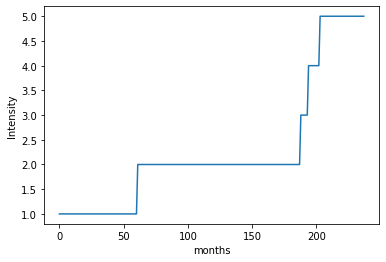

In [279]:
plot_gov_evolution(0.025,0.01,240,1)

In [236]:
evolutions = []
for i in range(1000): 
    evolutions.append(get_gov_evolution(0.025, 0.01, 240, 1))

In [237]:
avg_run = list(map(lambda x: sum(x)/len(x), zip(*evolutions)))

Text(0, 0.5, 'Intensity')

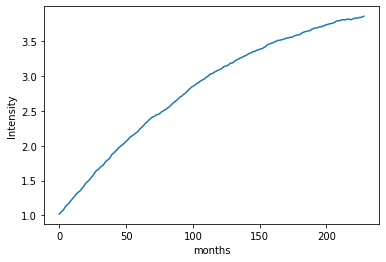

In [238]:
plt.plot(avg_run)
plt.xlabel('months')
plt.ylabel("Intensity")

# Mortgage
- What will be my monthly payment? 

In [287]:
from mortgage import Loan

loan = Loan(principal=65000000, interest=.03, term=20)
loan.summarize

Original Balance:         $ 65,000,000
Interest Rate:                    0.03 %
APY:                              3.04 %
APR:                              3.00 %
Term:                               20 years
Monthly Payment:          $  360488.44

Total principal payments: $65,000,000.00
Total interest payments:  $21,517,225.27
Total payments:           $86,517,225.27
Interest to principal:            33.1 %
Years to pay:                     20.0


# One step of the evolution 
- This will be used in monte carlo simulation after we obtain the optimal decision strategy from the ADP optimization. 

- Price evolution of power, gas and CO2. 
- Evolution of the government policy
- Evolution of project state based on actions 
- Evolution of repayment of the loans based on the state. 


## Price evolution of power
- Already somehow done in the beginning of this notebook. 

In [378]:
def get_next_price(current_price, volatility): 
    return(np.random.lognormal(np.log(current_price), volatility))

In [385]:
prices = []
current_price = 40
prices.append(current_price)

government_policy = 3

for i in range(300): 
    volatility = 0.05*((1+(government_policy-1)*0.2))
    current_price = get_next_price(current_price,0.05)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

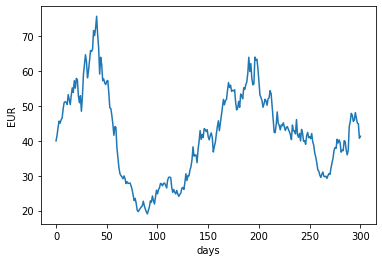

In [386]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

It looks somehow reasonable. 

## Price evolution for gas 
- Will be very similar to that of power. 

In [389]:
prices = []
current_price = 24
prices.append(current_price)

for i in range(300): 
    current_price = get_next_price(current_price,0.04)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

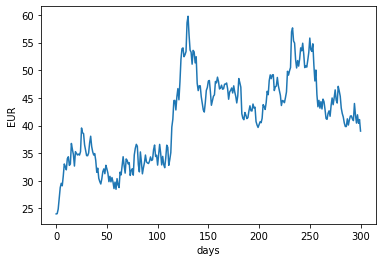

In [390]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

## Price evolution of CO2 
- now with a lower volatility

In [393]:
prices = []
current_price = 24
prices.append(current_price)

for i in range(300): 
    current_price = get_next_price(current_price,0.02)
    prices.append(current_price)

Text(0, 0.5, 'EUR')

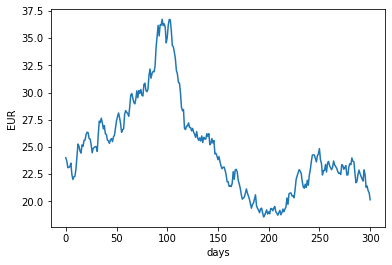

In [394]:
plt.plot(prices)
plt.xlabel('days')
plt.ylabel("EUR")

## Government policy evolution 
- Again was already done before, so it is only a reinterpretation. 

In [498]:
def get_next_gov_policy(gov_policy, negative_prob, positive_prob): 
    zero_prob = 1 - positive_prob - negative_prob
    
    movement = np.random.choice(np.arange(1, 4), p=[negative_prob, zero_prob, positive_prob, ])-2

    if(gov_policy+movement in range(1,6)):
        gov_policy = gov_policy + movement
    return(gov_policy)

In [499]:
gov_policy = 1

In [500]:
gov_policy = get_next_gov_policy(gov_policy, 0.03, 0.08)
gov_policy

1

In [563]:
gov_policies = []
gov_policy = 1
gov_policies.append(gov_policy)

for i in range(300): 
    gov_policy = get_next_gov_policy(gov_policy,0.007, 0.02)
    gov_policies.append(gov_policy)

Text(0, 0.5, 'intensity')

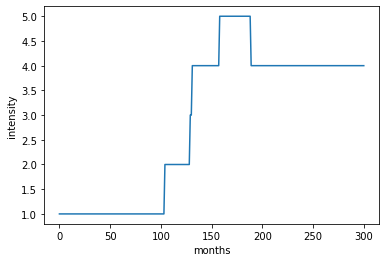

In [564]:
plt.plot(gov_policies)
plt.xlabel('months')
plt.ylabel("intensity")

## Project state based on action 
- State of production - 0: not running 1: running 2: not running mothballed
- Capacity of production - 0: 0MW, 1: 200MW, 2: 400MW  
    
- Two dimensions are not needed, there are only these actions possible: 
    - 0: Do not run and do not build the next stage - available in all states. 
    - 1: Run what is built and do not build new stage - available when there is something to run even mothballed. 
    - 2: Run what is built and build a new stage -  only available at 200MW capacity. 
    - 3: Do not run and build the next stage - only available at 200 MW capacity 
    - 4: mothball the plant 
    - 5: sell everything for salvage value
    
   

## Possible states encoding 
- \[0,0\] - power plant was not built yet. 

\[1,0\] and \[2,0\] - do not make sense. We encode one more state with this tuple [1,0] running at 0 MW will mean that we have sold the plant. 

\[0,1\] - 200MW installed and not running 

\[1,1\] = 200MW build and running 

\[1,2\] - 400MW built and running 

\[2,1\] - 200MW mothballed 

\[2,2\] - 400 MW mothballed

In [569]:
[[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 1], [2, 2]]

In [578]:
possible_states = [[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]
possible_actions = range(0,6)

In [621]:
[0,0] not in possible_states

False

In [906]:
def is_the_action_possible(state, action): 
    
    if (state not in possible_states): 
        print("The state: " +str(state)+ " is not allowed")
        return False
    
    if (action not in possible_actions): 
        print("This action is not allowed")
        return(False)
    
    # When the plant is sold, the only action allowed is to do nothing. 
    if (state == [1,0]): 
        if action != 0: 
            print("The plant was sold, no action that does something is allowed")
            return(False) 
    

    if action == 1: 
        if(state[1] == 0): 
            print("No capacity can be run. Installed capacity is 0")
            return(False)
        
    #Run 200 MW and build new stage
    if action == 2: 
        if(state[1] != 1): 
            print("Cannot run and build a new stage when the stage is not 200MW")
            return(False)
    
    if action == 3: 
        if(state[1] == 2): 
            print("Cannot build the new stage when the capacity is already 400MW. ")
            return(False)
        
    if action == 4:   
        if (state[1]==0): 
            print("There is nothing to mothball.")
            return(False)
    
    if action == 5: 
        if(state[1]==0): 
            print("There is nothing to sell")
            return(False)
        
    return(True)

In [907]:
def get_next_project_state(state, action): 
 
    if(not is_the_action_possible(state,action)): 
        print("The action " + str(action) + " is not possible in the state " + str(state))
        return(None)
    
    # If the plant was sold, I cannot 
    if (state == [1,0]): 
        return(state) 
    
    # Not runnig and not changing capacity. 
    if action == 0: 
        return([0, state[1]])

    # run what is build and not change capacity 
    if action == 1: 
        return([1,state[1]])

    #Run 200 MW and build new stage
    if action == 2: 
        return([1,2])

    #Do not run and build new stage: 
    if action == 3: 
        return([0,state[1]+1])
        
    # Mothball the plant 
    if action == 4: 
        return([2,state[1]])
    
    #Sell the plant 
    if action == 5:
        return([1,0])

In [908]:
not is_the_action_possible([0,0], 1)

No capacity can be run. Installed capacity is 0


True

In [909]:
get_next_project_state([0,0], 3)

[0, 1]

In [910]:
for state in possible_states: 
    for action in possible_actions: 
        print(str(state) + " " + str(action))
        print(get_next_project_state(state, action))

[0, 0] 0
[0, 0]
[0, 0] 1
No capacity can be run. Installed capacity is 0
The action 1 is not possible in the state [0, 0]
None
[0, 0] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 0]
None
[0, 0] 3
[0, 1]
[0, 0] 4
There is nothing to mothball.
The action 4 is not possible in the state [0, 0]
None
[0, 0] 5
There is nothing to sell
The action 5 is not possible in the state [0, 0]
None
[0, 1] 0
[0, 1]
[0, 1] 1
[1, 1]
[0, 1] 2
[1, 2]
[0, 1] 3
[0, 2]
[0, 1] 4
[2, 1]
[0, 1] 5
[1, 0]
[0, 2] 0
[0, 2]
[0, 2] 1
[1, 2]
[0, 2] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 2]
None
[0, 2] 3
Cannot build the new stage when the capacity is already 400MW. 
The action 3 is not possible in the state [0, 2]
None
[0, 2] 4
[2, 2]
[0, 2] 5
[1, 0]
[1, 0] 0
[1, 0]
[1, 0] 1
The plant was sold, no action that does something is allowed
The action 1 is not possible in the state [1, 0]
None
[

## Rewards from project state change
- There is a price for building new stage - actions 2 and 3 costing 65M EUR. 
- There is a reward for selling for salvage value, This is a function of time. 

- There is a cost to mothball the plant. 
- There is the same cost to unmothball the plant

In [911]:
powerplant_cost = 65000000
mothballing_cost = 500000
salvage_value_month = 50000 

In [912]:
def get_project_reward(state, action, time_left): 
    profit = 0
    
    if(not is_the_action_possible(state,action)): 
        return(profit)
    
    # Building new capacity 
    if action == 2 or action ==3: 
        profit = -powerplant_cost
    
    #Unmothballing
    if state[0]==2: 
        if(action in range(0,4)): 
            return(profit-mothballing_cost)
    else: #Mothballing
         if(action == 4): 
            return(profit - mothballing_cost) 

    # Selling for salvage value 
    if(action == 5): 
        return(state[1]*salvage_value_month*time_left)
    
    return(profit)

In [913]:
for state in possible_states: 
    for action in possible_actions: 
        print(str(state) + " " + str(action))
        print(get_next_project_state(state, action))
        print("Profit:" + str(get_project_reward(state,action, 5)))

[0, 0] 0
[0, 0]
Profit:0
[0, 0] 1
No capacity can be run. Installed capacity is 0
The action 1 is not possible in the state [0, 0]
None
No capacity can be run. Installed capacity is 0
Profit:0
[0, 0] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible in the state [0, 0]
None
Cannot run and build a new stage when the stage is not 200MW
Profit:0
[0, 0] 3
[0, 1]
Profit:-65000000
[0, 0] 4
There is nothing to mothball.
The action 4 is not possible in the state [0, 0]
None
There is nothing to mothball.
Profit:0
[0, 0] 5
There is nothing to sell
The action 5 is not possible in the state [0, 0]
None
There is nothing to sell
Profit:0
[0, 1] 0
[0, 1]
Profit:0
[0, 1] 1
[1, 1]
Profit:0
[0, 1] 2
[1, 2]
Profit:-65000000
[0, 1] 3
[0, 2]
Profit:-65000000
[0, 1] 4
[2, 1]
Profit:-500000
[0, 1] 5
[1, 0]
Profit:250000
[0, 2] 0
[0, 2]
Profit:0
[0, 2] 1
[1, 2]
Profit:0
[0, 2] 2
Cannot run and build a new stage when the stage is not 200MW
The action 2 is not possible 

Now it all fits. 

# Change in the payments state 
- If the new state provi

# Reward computation 
- First, write the FCF function, decide if it is enough for the loan payment and if yes, then subtract that and move the state of payments. 

In [914]:
number_of_payments = 240
payment_size = 360000

In [915]:
def get_next_payment_state(payment_state,FCF, action):
    ps = payment_state.copy()
    # building fist stage 
    if action == 2: 
        ps[0]=number_of_payments
        return(ps)
   
    # building the second stage
    if action == 3: 
        ps[1]=number_of_payments
        return(ps)
    
    #Repaying the payment 
    
    if FCF>payment_size: 
        if ps[0]>0: 
            ps[0] = ps[0]-1
            if FCF<payment_size*2: 
                return(ps)
            if ps[1]>0: 
                ps[1] = ps[1]-1
                return(ps)
        if ps[1]>0: 
            ps[1] = ps[1]-1
            
    return(ps)

In [916]:
get_next_payment_state([120,5],10000, 0)

[120, 5]

In [917]:
get_next_payment_state([120,5],500000, 0)

[119, 5]

In [918]:
get_next_payment_state([120,5],750000, 0)

[119, 4]

In [919]:
get_next_payment_state([0,0],0, 2)

[240, 0]

In [920]:
get_next_payment_state([5,0],0, 3)

[5, 240]

# FCF computation
- Now I will make the computation of FCF from the state and action

In [921]:
possible_project_states = [[i,j] for i in range(0,3) for j in range (0,3) if [i,j]!= [2,0]]


In [922]:
def state_not_valid(state):
    
    #Wrong state length 
    if len(state)!=8:
        return(True)
    
    # non-positive prices 
    if sum(np.sign(state[:3]))<3: 
        return(True)
    
    #Gov_policy in range
    if state[3] not in range (1,6): 
        return(True)
    
    #Loans in order: 
    if state[6] not in range(241) or state[7] not in range(241): 
        return(True)
    
    if state[4:6] not in possible_project_states: 
        return(True)
    
    return(False)   

In [923]:
state_not_valid([24,9,40,1,1,1,240,0])

False

In [924]:
state_not_valid([-2,9,40,1,1,1,240,0])

True

In [925]:
state_not_valid([9,9,0,1,1,1,240,0])

True

In [926]:
state_not_valid([9,9,24,0,1,1,240,0])

True

In [927]:
state_not_valid([9,9,24,4,2,0,240,0])

True

In [928]:
state_not_valid([9,9,24,4,2,2,-3,0])

True

In [929]:
state_not_valid([9,9,24,4,2,2,1,2])

False

In [930]:
maintanance_cost = 3

In [931]:
moth_maintanance_cost = 1

In [932]:
hours = 720 

In [933]:
MW_count = 200

In [934]:
def repayed(FCF, payment_state, action): 
    diff = [i-j for i,j in zip(payment_state,get_next_payment_state(payment_state, FCF, action))]
    valid_diff =[i for i in diff if i in range(0,2)]
    return(sum(valid_diff)*payment_size)

In [935]:
 valid_diff =[i for i in [1,1] if i in range(0,1)]

In [936]:
payment_state = [120,5]

In [937]:
get_next_payment_state(payment_state, 750000, 0)

[119, 4]

In [938]:
repayed(7500000, [0,0], 2)

0

In [939]:
0 in range(0,1)

True

In [940]:
payment_state = get_next_payment_state(payment_state, 750000, 0)
payment_state

[119, 4]

In [946]:
def get_FCF(state, action, time_left): 
    if(state_not_valid(state)): 
        print("The state is not valid")
        return None
    
    project_state = state[4:6]
    
    capacity = MW_count*project_state[1]
    
    reward = 0 
    
    #Plant is not running
    if project_state[0] == 0:
        #Capacity is non-zero
        if project_state[1] !=0: 
            reward = -maintanance_cost*capacity*hours
    
    #Plant is mothballed
    if project_state[0] == 2: 
        if project_state[1] !=0: 
            reward = -moth_maintanance_cost*capacity*hours
    
    if project_state[0] ==1: 
        gas_price = state[0]
        co2_price = state[1]
        power_price = state[2]

        #Reward from selling power
        print((power_price - gas_price - co2_price-maintanance_cost)*capacity*hours)
        reward += (power_price - gas_price - co2_price-maintanance_cost)*capacity*hours
    print(get_project_reward(project_state, action, time_left))
    reward += get_project_reward(project_state, action, time_left)
    
    print(repayed(reward, state[6:8], action))
    loan_payment = repayed(reward, state[6:8], action)
    
    return (reward - loan_payment)
    

In [948]:
get_FCF([24,9,40,1,1,1,239,0], 1, 40)

576000
0
360000


216000

Now I am able to model the evolution of the subset of the states plus I can compute the FCF of a given state. I am very close to an actual MC simulation based given some (for now heuristic) policy. 